In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
import geopandas as gpd 
from shapely.geometry import LineString
import math
import networkx as nx
%matplotlib inline

In [85]:
import warnings
warnings.filterwarnings('ignore')

In [86]:
dict_ine_name= {'02': 'Albacete',
 '03': 'Alicante/Alacant',
 '04': 'Almería',
 '01': 'Araba/Álava',
 '33': 'Asturias',
 '05': 'Ávila',
 '06': 'Badajoz',
 '07': 'Balears Illes',
 '08': 'Barcelona',
 '48': 'Bizkaia',
 '09': 'Burgos',
 '10': 'Cáceres',
 '11': 'Cádiz',
 '39': 'Cantabria',
 '12': 'Castellón/Castelló',
 '13': 'Ciudad Real',
 '14': 'Córdoba',
 '15': 'Coruña A',
 '16': 'Cuenca',
 '20': 'Gipuzkoa',
 '17': 'Girona',
 '18': 'Granada',
 '19': 'Guadalajara',
 '21': 'Huelva',
 '22': 'Huesca',
 '23': 'Jaén',
 '24': 'León',
 '25': 'Lleida',
 '27': 'Lugo',
 '28': 'Madrid',
 '29': 'Málaga',
 '30': 'Murcia',
 '31': 'Navarra',
 '32': 'Ourense',
 '34': 'Palencia',
 '35': 'Palmas Las',
 '36': 'Pontevedra',
 '26': 'Rioja La',
 '37': 'Salamanca',
 '38': 'Santa Cruz de Tenerife',
 '40': 'Segovia',
 '41': 'Sevilla',
 '42': 'Soria',
 '43': 'Tarragona',
 '44': 'Teruel',
 '45': 'Toledo',
 '46': 'Valencia/València',
 '47': 'Valladolid',
 '49': 'Zamora',
 '50': 'Zaragoza',
 '51': 'Ceuta',
 '52': 'Melilla'}

In [87]:
dict_name_ine = {}
for k, v in dict_ine_name.items():
    dict_name_ine[v] = k

In [88]:
gdf = gpd.read_file('Map/Provinces.shp', encoding='utf-8') 
gdf_points = gdf.copy()
gdf_points['geometry'] = gdf_points['geometry'].centroid
gdf_points['NPRO'] = gdf_points['NPRO'].str.replace(r'\,','')
gdf_points['NPRO'] = gdf_points['NPRO'].str.replace(r'Alicante', r'Alicante/Alacant')
gdf_points['NPRO'] = gdf_points['NPRO'].str.replace(r'Valencia/Valéncia', r'Valencia/València')

In [89]:
def preprocess(path):
    dtypes = {"Origen":str,
              "Destino":str,
              "Año":str,
              "Mes":str,
              "Día":str,
              "Periodo":str,
              "Modo":str,
              "Distancia":str,
              "Residencia":str,
              "Actividad_Origen":str,
              "Actividad_Destino":str,
              "Viajeros":str,
              "Viajeros-km":str}
    df = pd.read_csv(path, encoding="utf-8", dtype=dtypes)
    df['Viajeros'] = df['Viajeros'].str.replace(r'\,','').astype(float)
    df['Viajeros-km'] = df['Viajeros-km'].str.replace(r'\,','').astype(float)
    df['Origen2'] = df['Origen'].apply(lambda z: z[:2])
    df['Destino2'] = df['Destino'].apply(lambda z: z[:2])
    return df


In [90]:
def get_destino_distribution(df,Origen):
    destino_distribution = df[df.Origen2 == Origen].groupby('Destino2').Viajeros.sum().to_frame('weight')
    destino_distribution.reset_index(inplace=True)
    df_all_destino = pd.DataFrame([str(z).zfill(2) for z in range(1, 53)], columns=['Destino2'])
    destino_distribution = destino_distribution.merge(df_all_destino, on='Destino2', how='outer')
    destino_distribution.weight.fillna(0, inplace=True)
    destino_distribution['norm_weight'] = destino_distribution['weight'] / destino_distribution['weight'].sum()
    destino_distribution.sort_values('norm_weight', ascending=False, inplace=True)
    return destino_distribution

In [91]:
def get_distance_matrix(df):
    destino_distributions = {}
    destino_norm_distributions = {}
    for i in range(1, 53):
        origen = str(i).zfill(2)
        destino_distributions[origen] = get_destino_distribution(df, Origen=origen)
        destino_norm_distributions[origen] = destino_distributions[origen].norm_weight

    
    dist_mat = []
    destino_dist_avg = {}
    for i in range(1, 53):
        origen_i = str(i).zfill(2)
        array_i = []
        for j in range(1, 53):
            origen_j = str(j).zfill(2)
            array_i.append(jensenshannon(destino_norm_distributions[origen_i], 
                                         destino_norm_distributions[origen_j], 
                                         base=2))
        dist_mat.append(array_i)
        array_i = np.array(array_i)
        destino_dist_avg[origen_i] = np.nanmean(array_i)
    return dist_mat

In [92]:
def plot_dendrogram(dist_mat, thr,linkage_method, noplot = False):
    colors = ['Aqua','BlueViolet','Chartreuse','Chocolate','Crimson','DarkCyan','DarkGreen','DarkRed','DeepPink'
              ,'DodgerBlue','ForestGreen','Gold','Indigo','Lime','Magenta',
              'Olive', 'OrangeRed','Purple','Red','Salmon', 'SpringGreen',
              'Teal','Tomato','Violet']
    hierarchy.set_link_color_palette(colors)
    x = linkage(dist_mat,linkage_method)
    if noplot:
        return dendrogram(x, labels=[dict_ine_name[str(i).zfill(2)] for i in range(1, 53)], no_plot = True, leaf_rotation=90, above_threshold_color='b',color_threshold = thr,leaf_font_size =14)
    else: 
        plt.figure(figsize=(12, 6))
        g = dendrogram(x, labels=[dict_ine_name[str(i).zfill(2)] for i in range(1, 53)], leaf_rotation=90, above_threshold_color='b',color_threshold = thr,leaf_font_size =14)
        plt.axhline(y=thr, ls=':', color='k')
        plt.ylabel("Distance")
        plt.title(f'Linkage method:{linkage_method}')
        plt.tight_layout()

       # plt.savefig(f"{linkage_method}.pdf")
        return g

In [93]:
def plot_clustered_cities(group, title_name):
    #colors = np.unique(group['leaves_color_list']).tolist()
    colors = ['Aqua','BlueViolet','Chartreuse','Chocolate','Crimson','DarkCyan','DarkGreen','DarkRed','DeepPink'
              ,'DodgerBlue','ForestGreen','Gold','Indigo','Lime','Magenta',
              'Olive', 'OrangeRed','Purple','Red','Salmon', 'SpringGreen',
              'Teal','Tomato','Violet']
    color_city_group_dict = {}
    for color in group['leaves_color_list']:
        ind = [i for i, j in enumerate(group['leaves_color_list']) if j == color]
        color_city_group_dict[color]= [group['ivl'][i] for i in ind]

    group_coord = {}
    for color in color_city_group_dict.keys():
        cities = color_city_group_dict[color]
        group_coord[color] = [list(dict_ine_name.keys())[list(dict_ine_name.values()).index(city)] for city in cities]   


    ax = gdf.plot(facecolor='white', edgecolor='black', figsize=(10,8))
    ax.set_title(title_name)
    for x, y, label in zip(gdf_points.lon,gdf_points.lat, gdf_points.CPRO):
        ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
    for color,coord in group_coord.items() :
        gdf_points[gdf_points.CPRO.isin(coord)].plot(ax=ax, color=color, legend=True)
        gdf[gdf.CPRO.isin(coord)].plot(ax=ax, color=color, alpha=0.2)
        


In [98]:
def get_mobility_network(df):
    gdf_points['lon'] = gdf_points.geometry.apply(lambda z: z.coords[0][0])
    gdf_points['lat'] = gdf_points.geometry.apply(lambda z: z.coords[0][1])
    dict_lon = dict(zip(gdf_points.CPRO, gdf_points.lon))
    dict_lat = dict(zip(gdf_points.CPRO, gdf_points.lat))
    mobility_network = df.groupby(['Origen2', 'Destino2', ]).Viajeros.sum().to_frame('flow')
    mobility_network.reset_index(inplace=True)
    mobility_network['norm_flow'] = mobility_network.apply(lambda z: z.flow / mobility_network[mobility_network.Origen2 == z.Origen2].flow.sum(), axis=1)
    mobility_network['Origen_lon'] = mobility_network.Origen2.map(dict_lon)
    mobility_network['Origen_lat'] = mobility_network.Origen2.map(dict_lat)
    mobility_network['Destino_lon'] = mobility_network.Destino2.map(dict_lon)
    mobility_network['Destino_lat'] = mobility_network.Destino2.map(dict_lat)
    mobility_network['geometry'] = mobility_network.apply(lambda z: LineString([[z.Origen_lon, z.Origen_lat], [z.Destino_lon, z.Destino_lat]]), axis=1)
    mobility_network = gpd.GeoDataFrame(mobility_network, geometry='geometry')
    return mobility_network

In [124]:
def plot_network(mobility_network):
    fig = plt.figure(figsize=(8,10))
    ax = fig.add_subplot(1, 1, 1)

   
    gdf_points['lon'] = gdf_points.geometry.apply(lambda z: z.coords[0][0])
    gdf_points['lat'] = gdf_points.geometry.apply(lambda z: z.coords[0][1])
    dict_lon = dict(zip(gdf_points.CPRO, gdf_points.lon))
    dict_lat = dict(zip(gdf_points.CPRO, gdf_points.lat))
    g = nx.from_pandas_edgelist(mobility_network, 'Origen2', 'Destino2', ['flow', 'norm_flow'])
    pos = {x: (dict_lon.get(x, 0) , dict_lat.get(x, 0)) for x in set(dict_lat).union(dict_lon)}
    g.add_nodes_from(list(pos.keys()))
    nx.set_node_attributes(g, pos, 'coord')
    node_color = {}
    for idx,name in dict_ine_name.items():
        for k,v in color_city_group_dict.items():
            for i in range(len(v)):
                if v[i] == name:
                    node_color[idx] = k 
    nx.draw_networkx_nodes(g, pos = nx.get_node_attributes(g , 'coord'), ax = ax,node_size=300, node_color=node_color.values(), cmap=plt.cm.tab10)

    edgelist = [(u, v) for (u, v, d) in g.edges(data=True)]
    # edges
   # nx.draw_networkx_edges(g, pos, ax = ax,edgelist=edgelist, 
   #                        width=1, alpha=0.5, edge_color='grey')
    durations = [i['norm_flow']*10 for i in dict(g.edges).values()]
    nx.draw_networkx_edges(g, pos, ax = ax,edgelist=edgelist, 
                       width=durations,  edge_color='k')

    # labels
    nx.draw_networkx_labels(g, pos, ax = ax,font_size=12, font_family='Arial')

    plt.gca()
    ax.margins(0.08)
    plt.axis('off')
    plt.tight_layout()
    return g

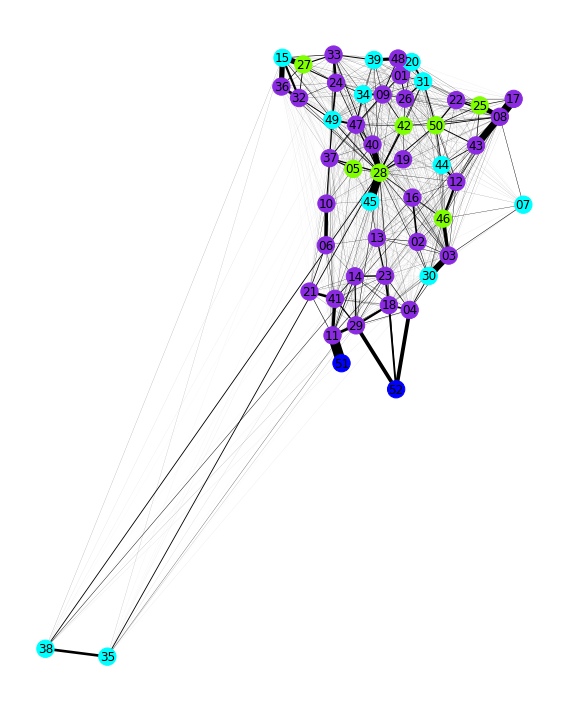

In [125]:
plot_network(mobility_network)

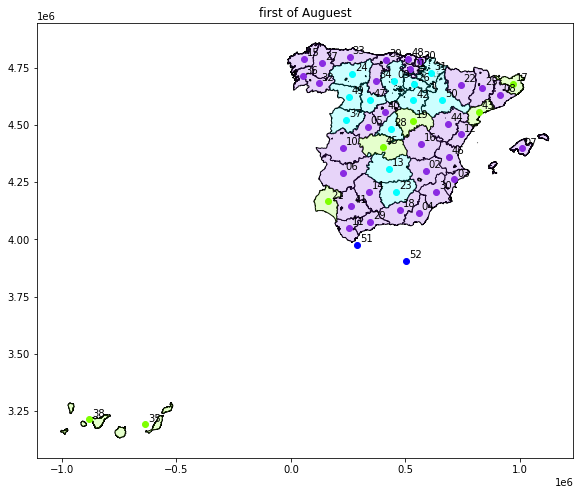

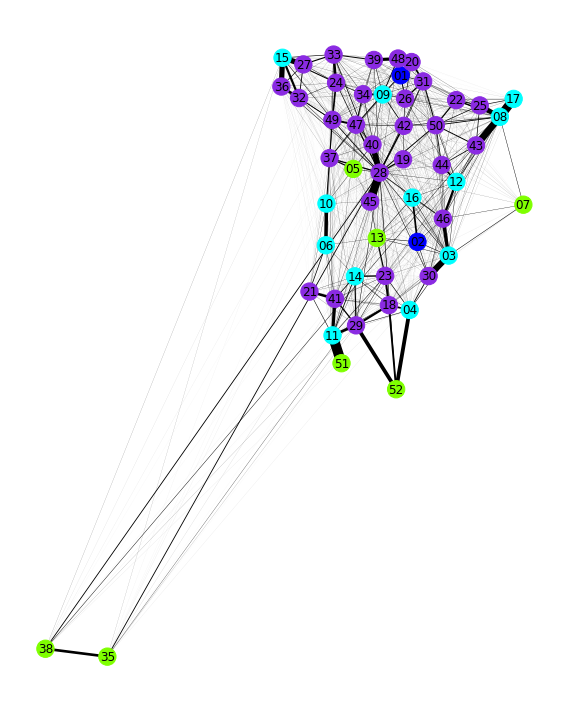

In [61]:
path = "July/ET_J10.csv" #first of Auguest
title_name = 'first of Auguest'
thr = .85
linkage_method = 'median'
df = preprocess(path)
dist_mat = get_distance_matrix(df)
group = plot_dendrogram(dist_mat,thr, linkage_method, noplot = True)
plot_clustered_cities(group, title_name)
mobility_network = get_mobility_network(df)
plot_network(mobility_network)

In [63]:
color_city_group_dict = {}
for color in group['leaves_color_list']:
    ind = [i for i, j in enumerate(group['leaves_color_list']) if j == color]
    color_city_group_dict[color]= [group['ivl'][i] for i in ind]
group_coord = {}
for color in color_city_group_dict.keys():
    cities = color_city_group_dict[color]
    group_coord[color] = [list(dict_ine_name.keys())[list(dict_ine_name.values()).index(city)] for city in cities]   
group_coord_list = list(group_coord.values())
colors = ['Aqua','BlueViolet','Chartreuse','Chocolate','Crimson','DarkCyan','DarkGreen','DarkRed','DeepPink'
          ,'DodgerBlue','ForestGreen','Gold','Indigo','Lime','Magenta',
          'Olive', 'OrangeRed','Purple','Red','Salmon', 'SpringGreen',
          'Teal','Tomato','Violet']

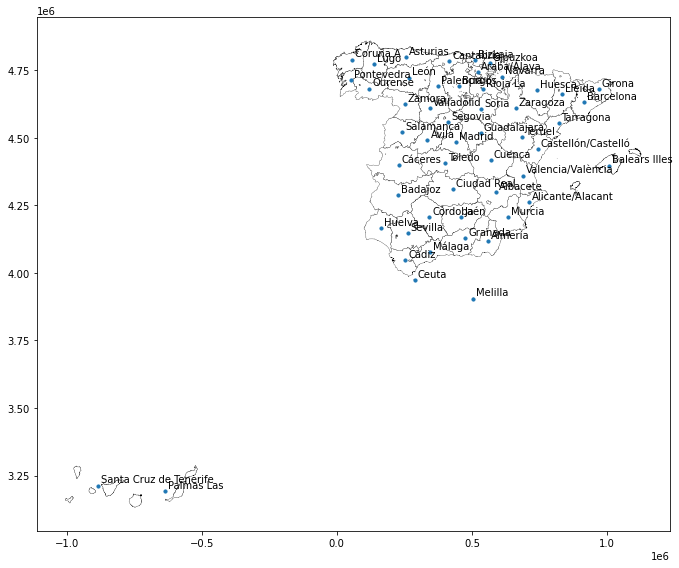

In [65]:
ax = gdf.plot(edgecolor='black', facecolor='white', figsize=(10, 8), linewidth=0.25)
gdf_points.plot(ax=ax, markersize=10)
for x, y, label in zip(gdf_points.lon,gdf_points.lat, gdf_points.NPRO):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
plt.tight_layout()

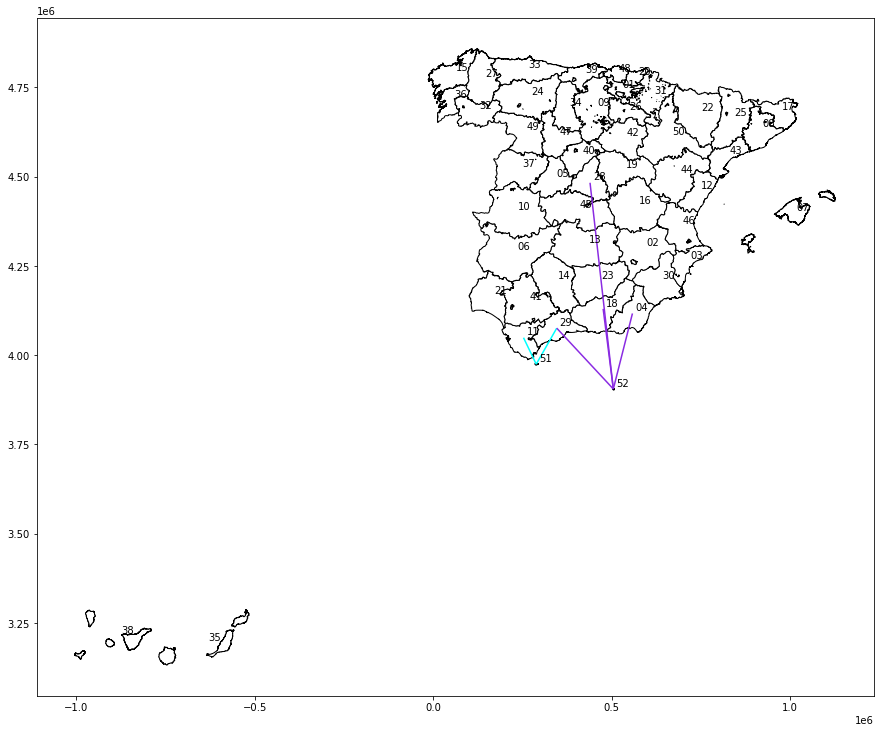

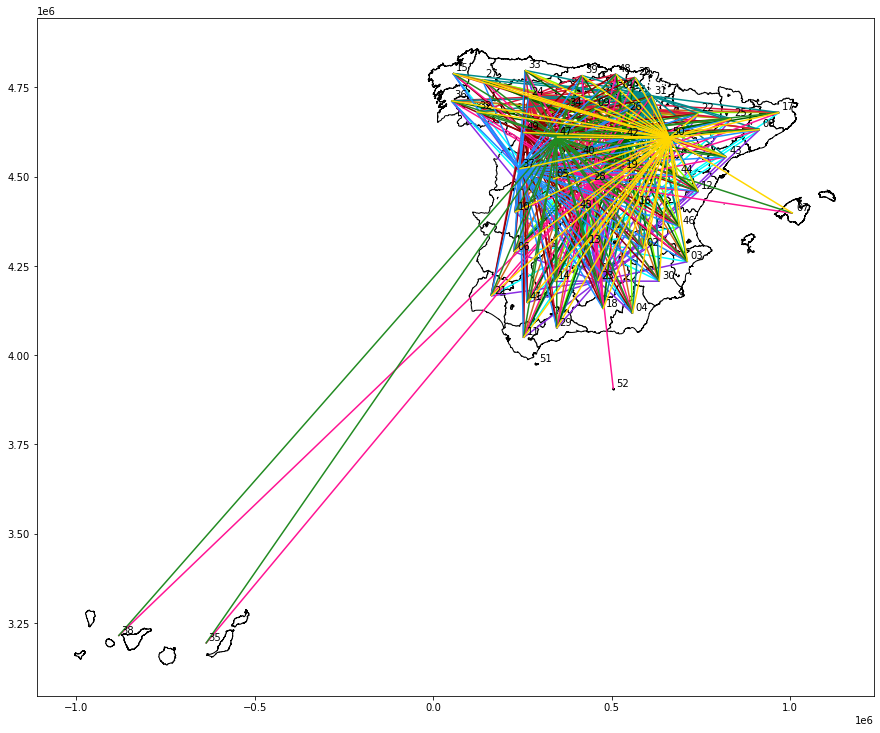

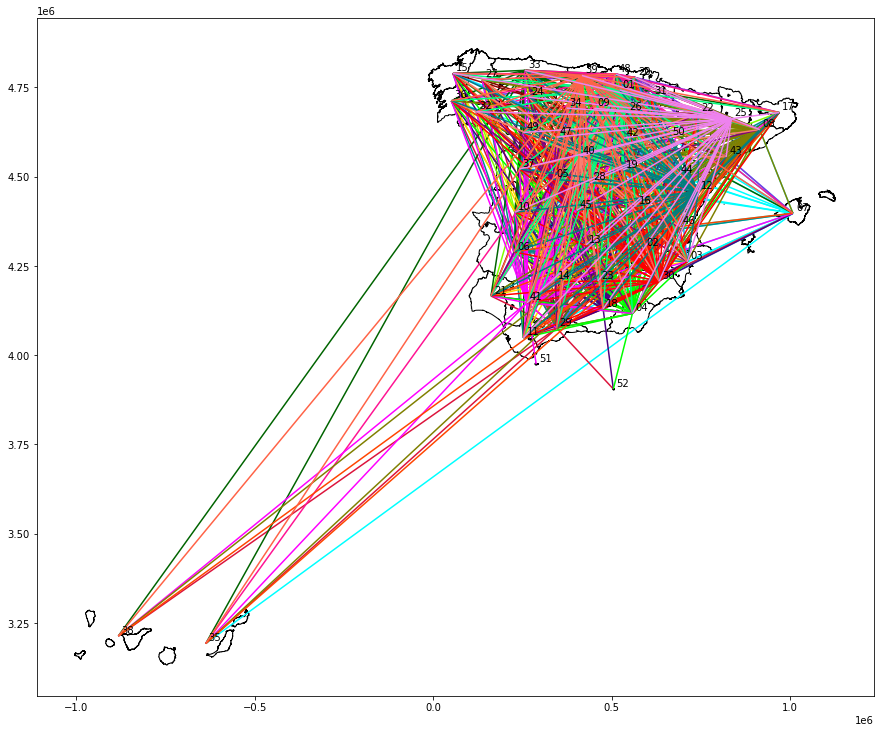

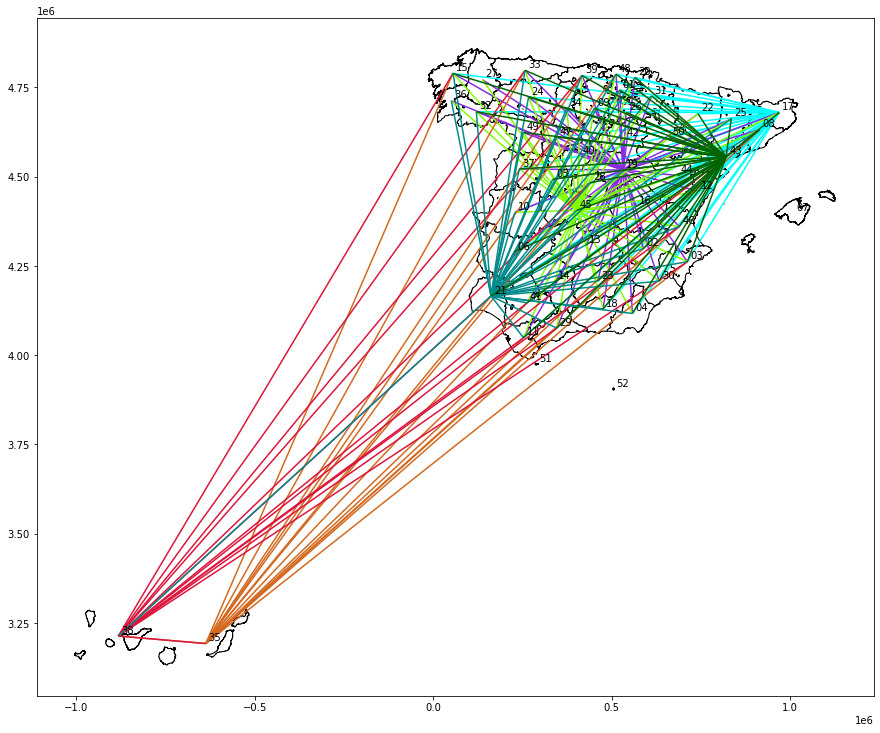

In [66]:
for i in range(len(group_coord_list)):    
    ax = gdf.plot(facecolor='white', edgecolor='black', figsize=(15, 15))
    for x, y, label in zip(gdf_points.lon,gdf_points.lat, gdf_points.CPRO):
        ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points")
    for city, color in zip(group_coord_list[i],colors):
        mobility_network[mobility_network.Origen2 == city].sort_values('norm_flow').plot(ax=ax, 
                                                                                     column='norm_flow', color = color, vmax=0.05, vmin=0)


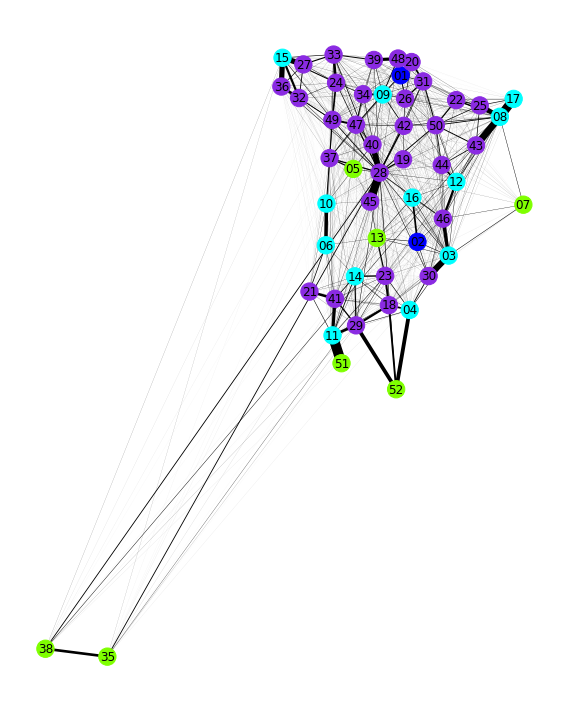

In [67]:
g = plot_network(mobility_network)

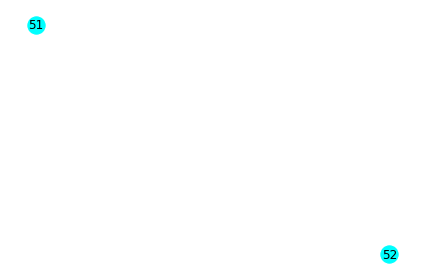

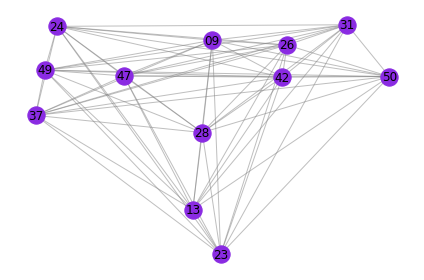

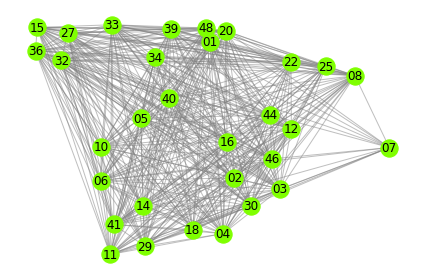

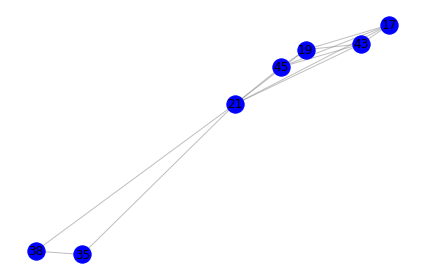

In [70]:

dict_lon = dict(zip(gdf_points.CPRO, gdf_points.lon))
dict_lat = dict(zip(gdf_points.CPRO, gdf_points.lat))
gdf_points['lon'] = gdf_points.geometry.apply(lambda z: z.coords[0][0])
gdf_points['lat'] = gdf_points.geometry.apply(lambda z: z.coords[0][1])
g = nx.from_pandas_edgelist(mobility_network, 'Origen2', 'Destino2', ['flow', 'norm_flow'])
unique_colors = np.unique(group['leaves_color_list']).tolist()
for i,c in enumerate(unique_colors):    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    
    s = g.subgraph(group_coord_list[i])
    pos = {x: (dict_lon.get(x, 0) , dict_lat.get(x, 0)) for x in set(dict_lat).union(dict_lon) if x in list(s.nodes)}
    nx.set_node_attributes(s, pos, 'coord')

    nx.draw_networkx_nodes(s, pos = nx.get_node_attributes(s , 'coord'), node_color = c, ax = ax,node_size=300, cmap=plt.cm.tab10)

    edgelist = [(u, v) for (u, v, d) in s.edges(data=True)]
    # edges
    nx.draw_networkx_edges(s, pos, ax = ax,edgelist=edgelist, 
                           width=1, alpha=0.5, edge_color='grey')

    # labels
    nx.draw_networkx_labels(s, pos, ax = ax,font_size=12, font_family='Arial')

    plt.gca()
    ax.margins(0.08)
    plt.axis('off')
    plt.tight_layout()



In [105]:
color_city_group_dict = {}
for color in group['leaves_color_list']:
    ind = [i for i, j in enumerate(group['leaves_color_list']) if j == color]
    color_city_group_dict[color]= [group['ivl'][i] for i in ind]

group_coord = {}
for color in color_city_group_dict.keys():
    cities = color_city_group_dict[color]
    group_coord[color] = [list(dict_ine_name.keys())[list(dict_ine_name.values()).index(city)] for city in cities]   
group_ivl = group['ivl']
group_color = group['leaves_color_list']

In [113]:
color_city_group_dict

{'b': ['Ceuta', 'Melilla'],
 'Aqua': ['Ciudad Real',
  'Jaén',
  'Rioja La',
  'Burgos',
  'León',
  'Navarra',
  'Soria',
  'Zamora',
  'Madrid',
  'Salamanca',
  'Valladolid',
  'Zaragoza'],
 'BlueViolet': ['Balears Illes',
  'Gipuzkoa',
  'Cáceres',
  'Albacete',
  'Málaga',
  'Badajoz',
  'Asturias',
  'Palencia',
  'Bizkaia',
  'Teruel',
  'Cuenca',
  'Córdoba',
  'Granada',
  'Almería',
  'Sevilla',
  'Barcelona',
  'Valencia/València',
  'Ávila',
  'Murcia',
  'Segovia',
  'Araba/Álava',
  'Castellón/Castelló',
  'Cantabria',
  'Lleida',
  'Huesca',
  'Cádiz',
  'Coruña A',
  'Ourense',
  'Lugo',
  'Alicante/Alacant',
  'Pontevedra'],
 'Chartreuse': ['Girona',
  'Guadalajara',
  'Toledo',
  'Palmas Las',
  'Santa Cruz de Tenerife',
  'Huelva',
  'Tarragona']}

In [119]:
sorted(node_color)

['01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52']